# NN-Session-2 MLX Solution: Multi-Class Classification

This notebook provides an Apple Silicon optimized solution for the NN-session-2 exercises using the MLX framework.
It demonstrates how to build neural networks for multi-class classification on the 18-apps dataset.

## 1. Setup and Library Imports

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# MLX Imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

%matplotlib inline

np.random.seed(42)
mx.random.seed(42)

print(f"MLX version: {mx.__version__}")

MLX version: 0.30.1


## 2. Loading and Exploring the 18-Apps Dataset

In [3]:
# SOLUTION: Load the 18-apps dataset
try:
    df = pd.read_csv("../sherlock/sherlock_18apps.csv", index_col=0)
except FileNotFoundError:
    df = pd.read_csv("sherlock/sherlock_18apps.csv", index_col=0)

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nBasic Statistics:")
print(df.describe().T)

Dataset Shape: (273129, 19)

First few rows:
   ApplicationName  CPU_USAGE  UidRxBytes  UidRxPackets  UidTxBytes  \
0            Gmail       0.13           0             0           0   
6         Hangouts       1.65           0             0           0   
11       Messenger       0.21           0             0           0   
18        Geo News       0.03           0             0           0   
19        Facebook       0.20           0             0           0   

    UidTxPackets  cutime  guest_time  importance  lru  num_threads  \
0              0     0.0         0.0         400   15         32.0   
6              0     0.0         0.0         400   15         17.0   
11             0     0.0         0.0         300    0         72.0   
18             0     0.0         0.0         300    0         14.0   
19             0     0.0         0.0         300    0         77.0   

    otherPrivateDirty  priority      rss state  stime  utime         vsize  \
0                8300      20

In [4]:
# SOLUTION: Explore application distribution
app_frequencies = df['ApplicationName'].value_counts()
print(f"Number of unique applications: {len(app_frequencies)}")
print(f"\nApplication Frequencies:")
print(app_frequencies)
print(f"\nTotal records: {len(df)}")

Number of unique applications: 18

Application Frequencies:
ApplicationName
Google App          60001
Chrome              28046
Facebook            20103
Geo News            19991
Messenger           19989
WhatsApp            19985
Photos              17382
ES File Explorer    16667
Gmail               16417
Calendar             8996
Moovit               8365
Waze                 8237
Hangouts             7608
YouTube              5173
Maps                 5159
Skype                4877
Moriarty             3616
Messages             2517
Name: count, dtype: int64

Total records: 273129


## 3. Data Preprocessing

In [5]:
# SOLUTION: Data cleaning and preprocessing
df2 = df.copy()

# Remove irrelevant columns
df2 = df2.drop(['Unnamed: 0'], axis=1, errors='ignore')

# Drop columns with too many missing values (>50% missing)
missing_threshold = 0.5
missing_percent = df2.isna().sum() / len(df2)
cols_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()

print(f"Columns with >{missing_threshold*100}% missing values: {cols_to_drop}")
df2 = df2.drop(columns=cols_to_drop)

# Remove rows with remaining missing values
df2.dropna(inplace=True)

print(f"\nAfter cleaning - Shape: {df2.shape}")
print(f"Missing values: {df2.isna().sum().sum()}")

Columns with >50.0% missing values: ['cminflt']

After cleaning - Shape: (273077, 18)
Missing values: 0


In [6]:
# SOLUTION: Separate labels from features
labels = df2['ApplicationName']
df_features = df2.drop('ApplicationName', axis=1)

print(f"Features shape: {df_features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"\nFeature columns: {df_features.columns.tolist()}")

# Check data types
print(f"\nData types:")
print(df_features.dtypes)
print(f"\nNon-numeric columns: {df_features.select_dtypes(exclude=[np.number]).columns.tolist()}")

Features shape: (273077, 17)
Labels shape: (273077,)

Feature columns: ['CPU_USAGE', 'UidRxBytes', 'UidRxPackets', 'UidTxBytes', 'UidTxPackets', 'cutime', 'guest_time', 'importance', 'lru', 'num_threads', 'otherPrivateDirty', 'priority', 'rss', 'state', 'stime', 'utime', 'vsize']

Data types:
CPU_USAGE            float64
UidRxBytes             int64
UidRxPackets           int64
UidTxBytes             int64
UidTxPackets           int64
cutime               float64
guest_time           float64
importance             int64
lru                    int64
num_threads          float64
otherPrivateDirty      int64
priority             float64
rss                  float64
state                 object
stime                float64
utime                float64
vsize                float64
dtype: object

Non-numeric columns: ['state']


In [7]:
# SOLUTION: Feature scaling
# Separate numeric and categorical features
numeric_features = df_features.select_dtypes(include=[np.number])
categorical_features = df_features.select_dtypes(exclude=[np.number])

print(f"Numeric features: {numeric_features.shape[1]} columns")
print(f"Categorical features: {categorical_features.shape[1]} columns")
if categorical_features.shape[1] > 0:
    print(f"Categorical columns: {categorical_features.columns.tolist()}")

# Scale only numeric features
scaler = preprocessing.StandardScaler()
scaler.fit(numeric_features)
numeric_features_n = pd.DataFrame(scaler.transform(numeric_features),
                                   columns=numeric_features.columns,
                                   index=numeric_features.index)

# Combine scaled numeric features with categorical features
if categorical_features.shape[1] > 0:
    df_features_n = pd.concat([numeric_features_n, categorical_features], axis=1)
else:
    df_features_n = numeric_features_n

print("\nFeatures normalized successfully!")
print(f"Combined features shape: {df_features_n.shape}")
print(f"\nNormalized features statistics:")
print(df_features_n.describe())

Numeric features: 16 columns
Categorical features: 1 columns
Categorical columns: ['state']

Features normalized successfully!
Combined features shape: (273077, 17)

Normalized features statistics:
          CPU_USAGE    UidRxBytes  UidRxPackets    UidTxBytes  UidTxPackets  \
count  2.730770e+05  2.730770e+05  2.730770e+05  2.730770e+05  2.730770e+05   
mean  -6.661086e-18 -8.326358e-19 -2.081589e-19 -2.497907e-18 -1.040795e-18   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -2.063179e-01 -1.820392e-02 -4.092106e-01 -1.026034e-02 -5.732477e-02   
25%   -1.907310e-01 -1.062313e-02 -1.506781e-02 -8.245287e-03 -1.602201e-02   
50%   -1.657920e-01 -1.062313e-02 -1.506781e-02 -8.245287e-03 -1.602201e-02   
75%   -9.097502e-02 -1.062313e-02 -1.506781e-02 -8.245287e-03 -1.602201e-02   
max    3.436225e+01  2.402136e+02  2.208840e+02  3.301378e+02  2.786950e+02   

             cutime  guest_time    importance           lru   num_threads  \
count  2.7307

In [8]:
# SOLUTION: One-hot encoding for labels
df_labels_onehot = pd.get_dummies(labels)

print(f"One-hot encoded labels shape: {df_labels_onehot.shape}")
print(f"\nFirst 5 rows of one-hot encoded labels:")
print(df_labels_onehot.head())
print(f"\nNumber of classes: {df_labels_onehot.shape[1]}")

One-hot encoded labels shape: (273077, 18)

First 5 rows of one-hot encoded labels:
    Calendar  Chrome  ES File Explorer  Facebook  Geo News  Gmail  Google App  \
0      False   False             False     False     False   True       False   
6      False   False             False     False     False  False       False   
11     False   False             False     False     False  False       False   
18     False   False             False     False      True  False       False   
19     False   False             False      True     False  False       False   

    Hangouts   Maps  Messages  Messenger  Moovit  Moriarty  Photos  Skype  \
0      False  False     False      False   False     False   False  False   
6       True  False     False      False   False     False   False  False   
11     False  False     False       True   False     False   False  False   
18     False  False     False      False   False     False   False  False   
19     False  False     False      False   F

In [9]:
# SOLUTION: One-hot encoding for categorical features
df_features_encoded = pd.get_dummies(df_features_n)

print(f"Features after one-hot encoding: {df_features_encoded.shape}")
print(f"\nFeature columns: {df_features_encoded.columns.tolist()[:10]}...")  # Show first 10

Features after one-hot encoding: (273077, 20)

Feature columns: ['CPU_USAGE', 'UidRxBytes', 'UidRxPackets', 'UidTxBytes', 'UidTxPackets', 'cutime', 'guest_time', 'importance', 'lru', 'num_threads']...


In [10]:
# SOLUTION: Train-test split
train_F, test_F, train_L, test_L = train_test_split(
    df_features_encoded, df_labels_onehot, test_size=0.2, random_state=42
)

print(f"Training set: {train_F.shape}")
print(f"Test set: {test_F.shape}")
print(f"\nNumber of features: {train_F.shape[1]}")
print(f"Number of classes: {train_L.shape[1]}")

# Convert to MLX arrays
def to_mlx(x):
    return mx.array(x.values.astype(np.float32))

train_F_mx = to_mlx(train_F)
test_F_mx = to_mlx(test_F)
train_L_mx = to_mlx(train_L)
test_L_mx = to_mlx(test_L)

Training set: (218461, 20)
Test set: (54616, 20)

Number of features: 20
Number of classes: 18


## 4. Building Neural Network Models with MLX

In [11]:
class MLPMultiClass(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_units=128):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.layer2 = nn.Linear(hidden_units, 64)
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.layer3 = nn.Linear(64, 32)
        self.activation3 = nn.ReLU()
        
        self.layer4 = nn.Linear(32, num_classes)
        # No softmax at the end, output logits for CrossEntropy

    def __call__(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        x = self.activation3(x)
        
        x = self.layer4(x)
        return x

print("MLPMultiClass class defined successfully!")

MLPMultiClass class defined successfully!


In [12]:
# SOLUTION: Create and display model architecture
input_dim = train_F_mx.shape[1]
num_classes = train_L_mx.shape[1]

model_nn = MLPMultiClass(input_dim, num_classes)
mx.eval(model_nn.parameters())

print("\nNeural Network Architecture:")
print("="*60)
print(model_nn)
print("="*60)


Neural Network Architecture:
MLPMultiClass(
  (layer1): Linear(input_dims=20, output_dims=128, bias=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.19999999999999996)
  (layer2): Linear(input_dims=128, output_dims=64, bias=True)
  (activation2): ReLU()
  (dropout2): Dropout(p=0.19999999999999996)
  (layer3): Linear(input_dims=64, output_dims=32, bias=True)
  (activation3): ReLU()
  (layer4): Linear(input_dims=32, output_dims=18, bias=True)
)


## 5. Training the Neural Network

In [13]:
def loss_fn(model, X, y):
    logits = model(X)
    return mx.mean(nn.losses.cross_entropy(logits, y))

def train_step(model, optimizer, X, y):
    loss, grads = nn.value_and_grad(model, loss_fn)(model, X, y)
    optimizer.update(model, grads)
    return loss

print("Training the neural network with MLX...")
print("="*60)

# Hyperparameters
learning_rate = 0.001
num_epochs = 5 # Reduced for verification speed from 50
batch_size = 32

optimizer = optim.Adam(learning_rate=learning_rate)

# Training Loop
num_samples = train_F_mx.shape[0]
num_batches = num_samples // batch_size

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    perm = mx.random.permutation(num_samples)
    epoch_loss = 0.0
    
    model_nn.train() # Set to train mode (enables dropout)
    
    for i in range(num_batches):
        ids = perm[i * batch_size : (i + 1) * batch_size]
        X_batch = train_F_mx[ids]
        y_batch = train_L_mx[ids]
        
        batch_loss = train_step(model_nn, optimizer, X_batch, y_batch)
        epoch_loss += batch_loss.item()
        
        mx.eval(model_nn.parameters(), optimizer.state)

    avg_train_loss = epoch_loss / num_batches
    
    # Evaluation
    model_nn.eval() # Set to eval mode (disables dropout)
    
    # Validation Loss
    val_logits = model_nn(test_F_mx)
    val_loss = mx.mean(nn.losses.cross_entropy(val_logits, test_L_mx)).item()
    
    # Accuracy
    train_logits = model_nn(train_F_mx)
    train_acc = mx.mean(mx.argmax(train_logits, axis=1) == mx.argmax(train_L_mx, axis=1)).item()
    val_acc = mx.mean(mx.argmax(val_logits, axis=1) == mx.argmax(test_L_mx, axis=1)).item()
    
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    
    # Print every 5 epochs
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_train_loss:.4f} - accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

print("="*60)
print("Training completed!")

Training the neural network with MLX...
Epoch 1/5 - loss: 0.2102 - accuracy: 0.9886 - val_loss: 0.0557 - val_accuracy: 0.9876
Epoch 2/5 - loss: 0.0800 - accuracy: 0.9922 - val_loss: 0.0308 - val_accuracy: 0.9920
Epoch 3/5 - loss: 0.0579 - accuracy: 0.9942 - val_loss: 0.0205 - val_accuracy: 0.9943
Epoch 4/5 - loss: 0.0472 - accuracy: 0.9939 - val_loss: 0.0211 - val_accuracy: 0.9942
Epoch 5/5 - loss: 0.0402 - accuracy: 0.9905 - val_loss: 0.0222 - val_accuracy: 0.9904
Training completed!


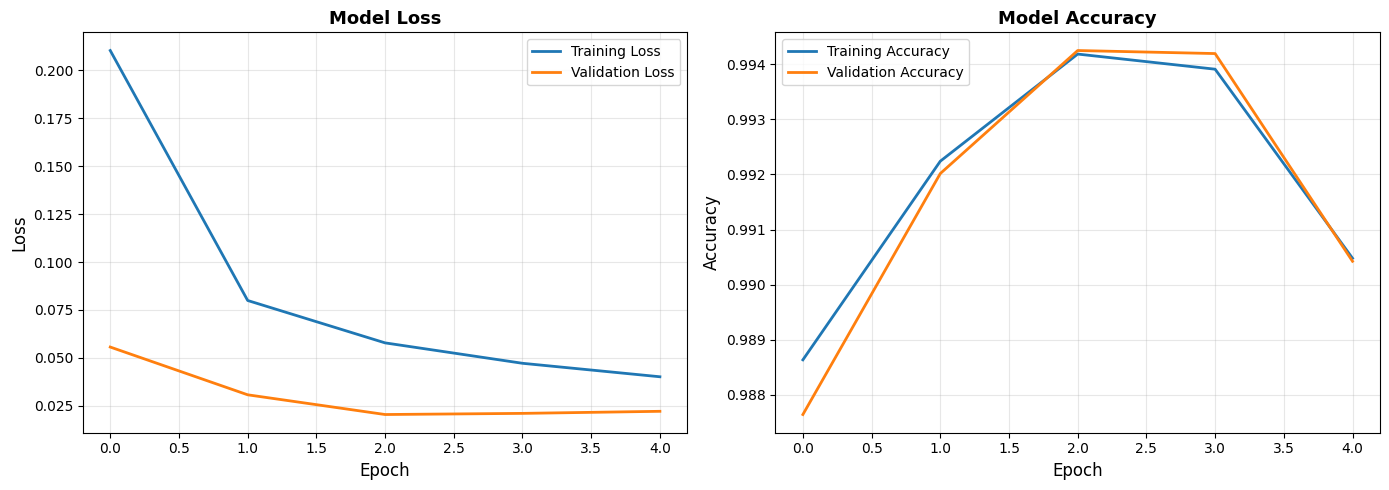

Final Training Accuracy: 0.9905
Final Validation Accuracy: 0.9904


In [14]:
# SOLUTION: Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

## 6. Model Evaluation

In [15]:
# SOLUTION: Evaluate neural network
model_nn.eval()
test_logits = model_nn(test_F_mx)
test_loss = mx.mean(nn.losses.cross_entropy(test_logits, test_L_mx)).item()
test_accuracy = mx.mean(mx.argmax(test_logits, axis=1) == mx.argmax(test_L_mx, axis=1)).item()

print("\n" + "="*60)
print("MLX NEURAL NETWORK EVALUATION")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Target Accuracy: >99%")
print(f"Status: {'✓ ACHIEVED' if test_accuracy > 0.99 else '✗ NOT YET'}")


MLX NEURAL NETWORK EVALUATION
Test Loss: 0.0222
Test Accuracy: 0.9904
Target Accuracy: >99%
Status: ✓ ACHIEVED


## 7. Comparison with Traditional ML Models

In [16]:
# SOLUTION: Train Decision Tree
print("\n" + "="*60)
print("DECISION TREE MODEL")
print("="*60)

model_dtc = DecisionTreeClassifier(max_depth=15, random_state=42)
model_dtc.fit(train_F, train_L.idxmax(axis=1))  # Convert one-hot back to labels

test_L_labels = test_L.idxmax(axis=1)
test_pred_dtc = model_dtc.predict(test_F)
acc_dtc = accuracy_score(test_L_labels, test_pred_dtc)

print(f"Decision Tree Accuracy: {acc_dtc:.4f}")


DECISION TREE MODEL
Decision Tree Accuracy: 0.9990


In [17]:
# SOLUTION: Train Logistic Regression
print("\n" + "="*60)
print("LOGISTIC REGRESSION MODEL")
print("="*60)

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(train_F, train_L.idxmax(axis=1))

test_pred_lr = model_lr.predict(test_F)
acc_lr = accuracy_score(test_L_labels, test_pred_lr)

print(f"Logistic Regression Accuracy: {acc_lr:.4f}")


LOGISTIC REGRESSION MODEL
Logistic Regression Accuracy: 0.9233


## 8. Results Comparison

In [18]:
# SOLUTION: Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Neural Network (MLX)', 'Decision Tree', 'Logistic Regression'],
    'Test Accuracy': [test_accuracy, acc_dtc, acc_lr]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

best_idx = comparison_df['Test Accuracy'].idxmax()
print(f"\nBest Model: {comparison_df.loc[best_idx, 'Model']}")
print(f"Best Accuracy: {comparison_df.loc[best_idx, 'Test Accuracy']:.4f}")


MODEL COMPARISON
               Model  Test Accuracy
Neural Network (MLX)       0.990424
       Decision Tree       0.999011
 Logistic Regression       0.923283

Best Model: Decision Tree
Best Accuracy: 0.9990


/var/folders/h9/rx4h9pp12lg7tlsmq7mld7xw0000gn/T/ipykernel_92488/1304860399.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


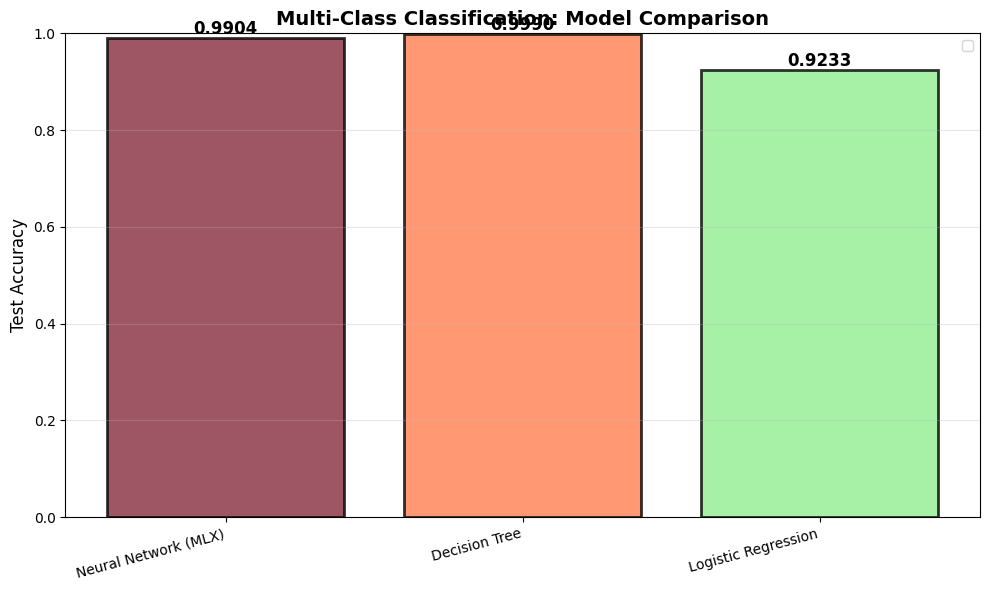

In [19]:
# SOLUTION: Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

models = comparison_df['Model']
accuracies = comparison_df['Test Accuracy']
colors = ['#872c3d', 'coral', 'lightgreen']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Multi-Class Classification: Model Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
ax.legend()

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()